In [2]:
import torchvision.models as models
import torchfunc
import torch
from torchsummary import summary

In [3]:
resnet18 = models.resnet18(pretrained=True)
vgg16 = models.vgg16(pretrained=True)

In [48]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [72]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [73]:
summary(resnet18, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

In [70]:
import torch
import torch.nn as nn
from torch.autograd import Variable

from collections import OrderedDict
import numpy as np



def summary_string(model, input_size, batch_size=-1, device=torch.device('cpu:0'), dtypes=None):
    if dtypes == None:
        dtypes = [torch.FloatTensor]*len(input_size)

    summary_str = ''

    def register_hook(module):
        def hook(module, input, output):
            class_name = str(module.__class__).split(".")[-1].split("'")[0]
            module_idx = len(summary)

            m_key = "%s-%i" % (class_name, module_idx + 1)
            summary[m_key] = OrderedDict()
            summary[m_key]["input_shape"] = list(input[0].size())
            summary[m_key]["input_shape"][0] = batch_size
            if isinstance(output, (list, tuple)):
                summary[m_key]["output_shape"] = [
                    [-1] + list(o.size())[1:] for o in output
                ]
            else:
                summary[m_key]["output_shape"] = list(output.size())
                summary[m_key]["output_shape"][0] = batch_size

            params = 0
            if hasattr(module, "weight") and hasattr(module.weight, "size"):
                params += torch.prod(torch.LongTensor(list(module.weight.size())))
                summary[m_key]["trainable"] = module.weight.requires_grad
            if hasattr(module, "bias") and hasattr(module.bias, "size"):
                params += torch.prod(torch.LongTensor(list(module.bias.size())))
            summary[m_key]["nb_params"] = params

        if (
            not isinstance(module, nn.Sequential)
            and not isinstance(module, nn.ModuleList)
        ):
            hooks.append(module.register_forward_hook(hook))

    # multiple inputs to the network
    if isinstance(input_size, tuple):
        input_size = [input_size]

    # batch_size of 2 for batchnorm
    x = [torch.rand(2, *in_size).type(dtype).to(device=device)
         for in_size, dtype in zip(input_size, dtypes)]

    # create properties
    summary = OrderedDict()
    hooks = []

    # register hook
    model.apply(register_hook)

    # make a forward pass
    # print(x.shape)
    model(*x)

    # remove these hooks
    for h in hooks:
        h.remove()
    layer_inputs = []
    layer_wts = []
    wts_reuse = []
    data_reuse = []
    ct = 0
    total_activation = 0
    for layer in summary:
        ct += 1
        if ct in linear_layers:
            inputx = summary[layer]["input_shape"]
            outputx = summary[layer]["output_shape"]
            data_reuse.append(outputx[1]) # N
            #wts_reuse.append(0)
            #layer_inputs.append(inputx[1])
            #total_activation += inputx[1]
            #layer_wts.append(summary[layer]["nb_params"].item())
        elif ct in conv_layers:
            inputx = summary[layer]["input_shape"]
            outputx = summary[layer]["output_shape"]
            data_reuse.append(int(summary[layer]["nb_params"].item()/inputx[1]))
            #wts_reuse.append(outputx[2]*outputx[3])
            #layer_inputs.append(inputx[1]*inputx[2]*inputx[3])
            #total_activation += inputx[1]*inputx[2]*inputx[3]
            #layer_wts.append(summary[layer]["nb_params"].item())
        else:
            inputx = summary[layer]["input_shape"]
            #total_activation += inputx[1]*inputx[2]*inputx[3]
    return data_reuse
conv_layers = [1,5,8,12,15,19,22,24,28,31,35,38,40,44,47,51,54,56,60,63]
linear_layers = [68]
resnet_data_reuse = summary_string(resnet18,(3,32,32))
resnet_idx = conv_layers + linear_layers
print(resnet_data_reuse)

conv_layers = [1,3,6,8,11,13,15,18,20,22,25,27,29]
linear_layers = [33,36,39]
vgg_data_reuse = summary_string(vgg16,(3,32,32))

vgg_idx = conv_layers + linear_layers
print(vgg_data_reuse)

[3136, 576, 576, 576, 576, 1152, 1152, 128, 1152, 1152, 2304, 2304, 256, 2304, 2304, 4608, 4608, 512, 4608, 4608, 1000]
[597, 577, 1154, 1153, 2306, 2305, 2305, 4610, 4609, 4609, 4609, 4609, 4609, 4096, 4096, 1000]


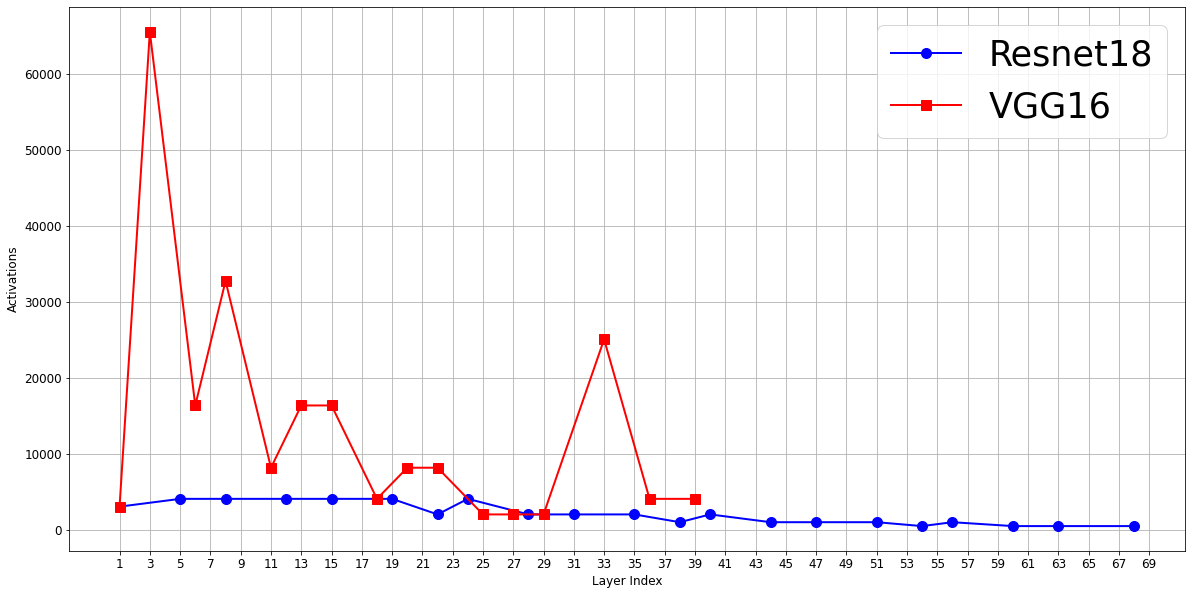

In [63]:
import matplotlib as mpl
import matplotlib.pyplot as plt
# activations
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
line1, = ax.plot(resnet_idx,resnet_inputs,label='Resnet18',linewidth=2,color='b',marker='o',markersize=10)
line2, = ax.plot(vgg_idx,vgg_inputs,label='VGG16',linewidth=2,color='r',marker='s',markersize=10)
plt.legend(handles=[line1,line2],loc=0,fontsize=35)
ax.grid()
ax.set_xlabel('Layer Index',fontsize=12)
ax.set_ylabel('Activations',fontsize=12)
ax.tick_params(axis='both',labelsize=12)
ax.set_xticks(np.arange(1,70,2))
plt.show()

ValueError: x and y must have same first dimension, but have shapes (21,) and (0,)

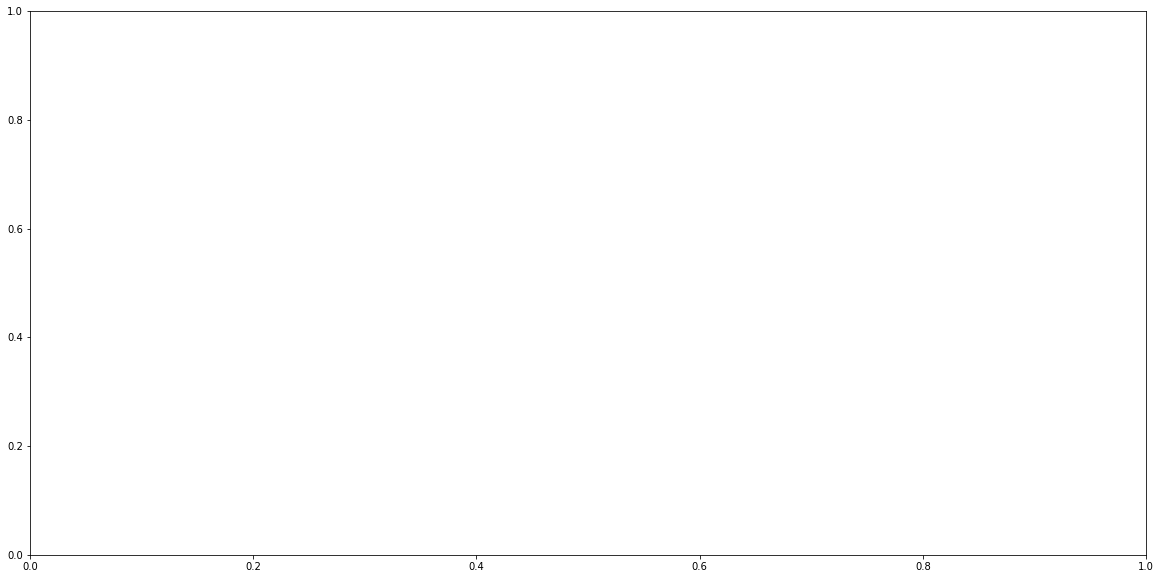

In [74]:
# weights
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
line1, = ax.plot(resnet_idx,resnet_wts,label='Resnet18',linewidth=2,color='b',marker='o',markersize=10)
line2, = ax.plot(vgg_idx,vgg_wts,label='VGG16',linewidth=2,color='r',marker='s',markersize=10)
plt.legend(handles=[line1,line2],loc=0,fontsize=35)
ax.grid()
ax.set_xlabel('Layer Index',fontsize=12)
ax.set_ylabel('Weights',fontsize=12)
ax.tick_params(axis='both',labelsize=12)
ax.set_xticks(np.arange(1,70,2))
plt.show()

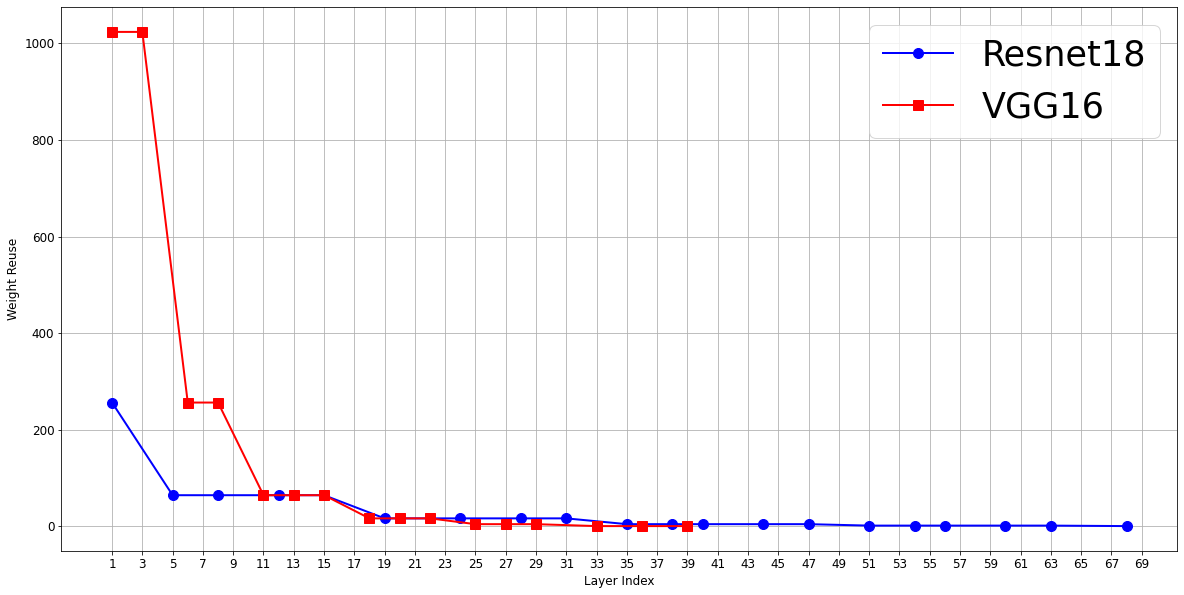

In [68]:
# weights reuse
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
line1, = ax.plot(resnet_idx,resnet_wts_reuse,label='Resnet18',linewidth=2,color='b',marker='o',markersize=10)
line2, = ax.plot(vgg_idx,vgg_wts_reuse,label='VGG16',linewidth=2,color='r',marker='s',markersize=10)
plt.legend(handles=[line1,line2],loc=0,fontsize=35)
ax.grid()
ax.set_xlabel('Layer Index',fontsize=12)
ax.set_ylabel('Weight Reuse',fontsize=12)
ax.tick_params(axis='both',labelsize=12)
ax.set_xticks(np.arange(1,70,2))
plt.show()

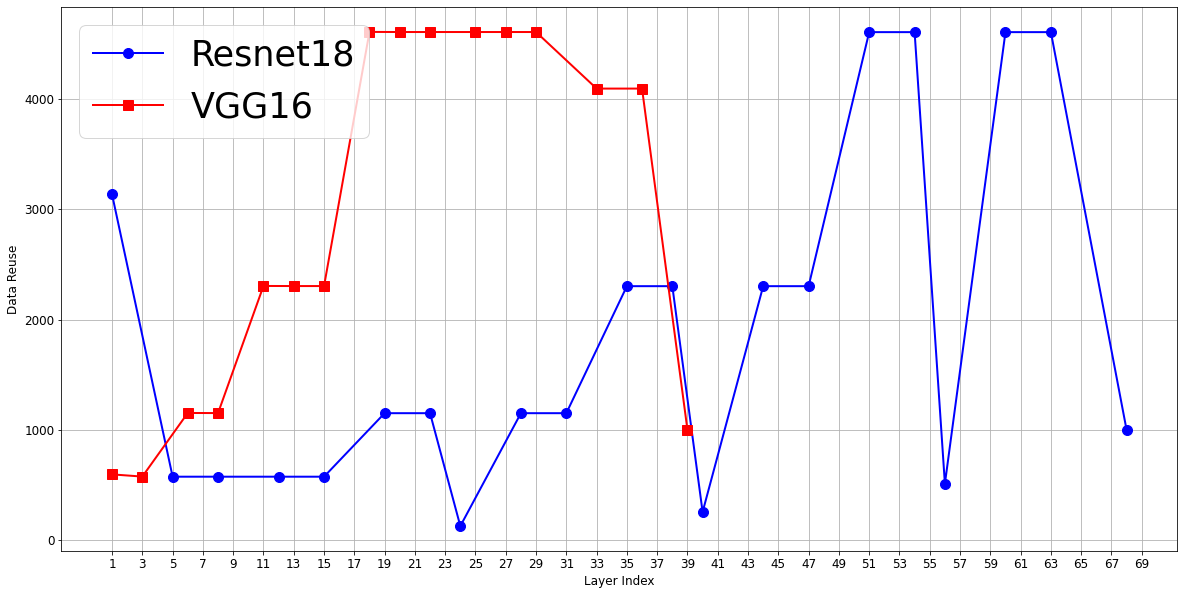

In [71]:
# data reuse
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
line1, = ax.plot(resnet_idx,resnet_data_reuse,label='Resnet18',linewidth=2,color='b',marker='o',markersize=10)
line2, = ax.plot(vgg_idx,vgg_data_reuse,label='VGG16',linewidth=2,color='r',marker='s',markersize=10)
plt.legend(handles=[line1,line2],loc=0,fontsize=35)
ax.grid()
ax.set_xlabel('Layer Index',fontsize=12)
ax.set_ylabel('Data Reuse',fontsize=12)
ax.tick_params(axis='both',labelsize=12)
ax.set_xticks(np.arange(1,70,2))
plt.show()